On June 10th, 2017, "The Tax Divide" was published to the Chicago Tribune, highlighting Cook County's property tax system and the unfair burden it placed on residents during the late 2000s through the mid 2010s. The articles presented its own analysis of property assessments and tax rates in relation to median household income, percentage of white residents, and appeal rate. The results revealed a systematic problem in the way Cook County assessed properties, leading to a regressive tax system that targeted lower-income, minority homeowners.


In response, the Cook County Assessor's Office began to publicize its data and the algorithms it uses in order to maintain and uphold transparency with the Cook County constituents. Under the newly elected assessor, Fritz Kaegi, Cook County would see more distributional equity in property taxation, meaning that properties with similar characteristics would be fairly assessed.


The data we will be exploring in this case study is from the Open Data collection from the Cook County Government, consisting of residential property characteristics and the final sale price of each property from 2013 to 2019.

Our goal is to first ask the question: Can we accurately predict the value of a property given its characteristics? Then, we can start exploring our data and gather which features may or may not be relevant in training a model. Finally, we can move onto actually creating a model that we can fine tune and grade via accuracy to the true sale values of a home.


Let's begin by unzipping our data and importing the necessary libraries:


In [6]:
import numpy as np
import polars as pl

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings('ignore')

import zipfile
import os

with zipfile.ZipFile('data\cook_county_data.zip') as f:
    f.extractall('data')

Let's print the contents of the data folder after extracting the zip file:


In [7]:
for file in os.listdir('data'):
    print(file)

cook_county_data.zip
cook_county_test.csv
cook_county_train.csv


Our dataset has already been split into test and training sets, but we'll only be working with the training set for the exploratory data analysis (EDA).


In [12]:
training_data = pl.read_csv('data\cook_county_train.csv')
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Design Plan,Cathedral Ceiling,Construction Quality,Site Desirability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Estimate (Land),Estimate (Building),Deed No.,Sale Price,Longitude,Latitude,Census Tract,Multi Property Indicator,Modeling Group,Age,Use,O'Hare Noise,Floodplain,Road Proximity,Sale Year,Sale Quarter,Sale Half-Year,Sale Quarter of Year,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
i64,i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,i64,str,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,str,f64
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1,0.0,1280.0,2.0,2.0,0.0,50000,139500,1525745095,1,-87.654264,41.840803,600600.0,0,"""SF""",132,1,0.0,0.0,0.0,2015,75,38,3,9,2,1.0,13.2,0,0.0,50,7650,"""This property,…",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,2.0,5.0,0.0,1.0,2.0,3,0.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,1,0.0,997.0,2.0,2.0,0.0,49140,177500,1814316064,285000,-87.735966,41.933016,200100.0,0,"""SF""",96,1,0.0,0.0,0.0,2018,86,43,2,5,1,1.0,9.6,1,1.0,120,71120,"""This property,…",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,0.0,2.0,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,907.0,2.0,2.0,0.0,26250,63470,1604916034,22000,-87.616496,41.686738,491400.0,0,"""SF""",112,1,0.0,0.0,0.0,2016,77,39,1,2,1,0.0,11.2,1,1.0,210,70210,"""This property,…",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,1.0,5.0,1.0,1.0,2.0,1,2.0,0.0,2.0,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,1174.0,2.0,2.0,0.0,29530,194430,1320441110,225000,-87.701482,42.019937,810301.0,0,"""SF""",63,1,0.0,0.0,0.0,2013,67,34,3,7,2,1.0,6.3,1,1.0,220,17220,"""This property,…",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,2.0,5.0,0.0,0.0,1.0,3,2.0,0.0,2.0,2.0,1.0,3.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,949.0,2.0,2.0,0.0,23100,30160,1616242072,22600,-87.682236,41.47643,830300.0,0,"""SF""",63,1,0.0,0.0,1.0,2016,78,39,2,6,1,0.0,6.3,1,1.0,120,32120,"""This property,…",8400.0


In this particular case study, we'll be using `Polars` in place of `pandas`. `Polars` is an alternative dataframe library that boasts greater performance and speed compared to `pandas`. It is written in Rust as a 'multi-threaded query engine' and is designed for 'effective parallelism', taking advantage of multiple cores compared to just one. My particular reason for using `Polars` is to familiarize myself with the library, since I already have prior experience using `pandas`.


Our dataset has 63 columns, ranging from numeric classifiers (i.e. PIN, property class) to continuous variables (i.e. building square feet). A codebook (`codebook.txt`) has also been provided to explain in further detail what each column means/represents. For example, the 'Age' column has a lengthy description that goes into detail about how a property's age has been entered:

"Age of the property. If missing, this defaults to 10. This field is a combination of original age and effective age where original age refers to the oldest component of the building and effective age is a relative judgment due to renovations or other improvements. For instance, if a property is completely demolished and built up again, the age resets to 1. But if portions of the original structure are kept, it may be more complicated to determine the age."


Let's begin with looking through the codebook and seeing which columns we can drop:


In [13]:
training_data = training_data.drop(["PIN",
                                    "Construction Quality",
                                    "Site Desirability",
                                    "Other Improvements",
                                    "Longitude",
                                    "Latitude",
                                    "Census Tract",
                                    "Neighborhood Code (mapping)",
                                    "Town and Neighborhood"])
training_data.head()

,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Design Plan,Cathedral Ceiling,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Estimate (Land),Estimate (Building),Deed No.,Sale Price,Multi Property Indicator,Modeling Group,Age,Use,O'Hare Noise,Floodplain,Road Proximity,Sale Year,Sale Quarter,Sale Half-Year,Sale Quarter of Year,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Description,Lot Size
i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,str,f64
0,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1,1280.0,2.0,2.0,0.0,50000,139500,1525745095,1,0,"""SF""",132,1,0.0,0.0,0.0,2015,75,38,3,9,2,1.0,13.2,0,0.0,50,"""This property,…",2500.0
1,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,2.0,5.0,0.0,1.0,2.0,3,0.0,0.0,2.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,1,997.0,2.0,2.0,0.0,49140,177500,1814316064,285000,0,"""SF""",96,1,0.0,0.0,0.0,2018,86,43,2,5,1,1.0,9.6,1,1.0,120,"""This property,…",3780.0
2,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,0.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,907.0,2.0,2.0,0.0,26250,63470,1604916034,22000,0,"""SF""",112,1,0.0,0.0,0.0,2016,77,39,1,2,1,0.0,11.2,1,1.0,210,"""This property,…",4375.0
3,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,1.0,5.0,1.0,1.0,2.0,1,2.0,0.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,1174.0,2.0,2.0,0.0,29530,194430,1320441110,225000,0,"""SF""",63,1,0.0,0.0,0.0,2013,67,34,3,7,2,1.0,6.3,1,1.0,220,"""This property,…",4375.0
4,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,2.0,5.0,0.0,0.0,1.0,3,2.0,0.0,1.0,3.0,2.0,2.0,7.0,0.0,0.0,0.0,3,949.0,2.0,2.0,0.0,23100,30160,1616242072,22600,0,"""SF""",63,1,0.0,0.0,1.0,2016,78,39,2,6,1,0.0,6.3,1,1.0,120,"""This property,…",8400.0


The columns that were dropped were ones that would not be of importance when fitting to a model, such as "PIN" and geographic data. Columns like "Construction Quality" and "Site Desirability" were explicitly mentioned in the codebook to be not useful for modeling.


Let's visualize the distribution of the outcome variable, Sale Price:


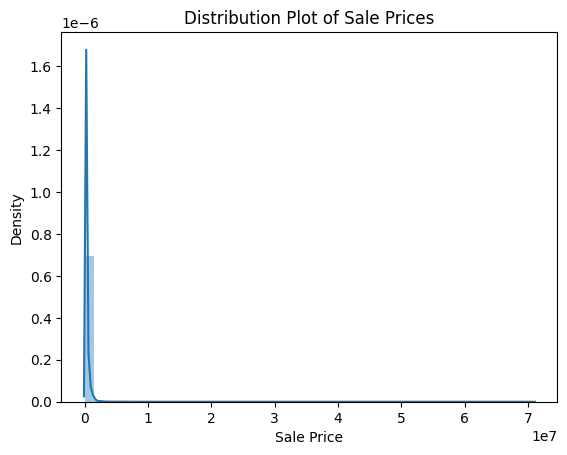

In [22]:
sns.distplot(training_data['Sale Price'])
plt.title('Distribution Plot of Sale Prices');

Since the distribution is heavily skewed, we'll apply a log transformation for a better visualization.


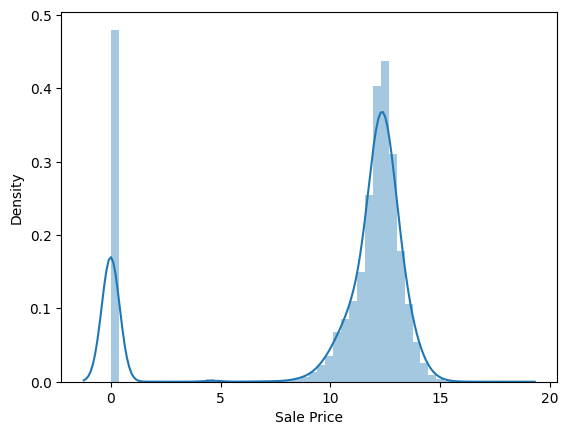

In [18]:
sns.distplot(np.log(training_data['Sale Price']))
plt.xlabel('Log Sale Price')
plt.title('Distribution Plot of Log Sale Prices');

The above distribution is better, but reveals that our data has outliers located near 0. We'll keep this in mind to potentially filter outliers from our training set.
